# Lab 4 Project (Titanic)

- **Author:** Aaron Gilllespie 
- **Date:** 2025-004-04
- **Objective:** Utilizing data from the Titanic manifest to train & test various types of classfiers.

This code base is being created in the course of completing module 4 of CSIS 44-670 from NW Missouri University. In this Jupyter Notebook which we will analyze data representing the passengers from the RMS Titanic, which sank in a very famous James Cameron movie (also real life). We are utilizing this dataset to, which [some research suggests](https://www.geeksforgeeks.org/python-titanic-data-eda-using-seaborn/) is a commonly utilized dataset for getting started with Machine Learning. In essence, this is the `hello world!` of my adventures with machine learning. 

In this lab we're exploring the prediction of a continuous target (i.e. not a simple binary classifier), the _fare_ paid by the passengers of the Titanic.

## Section 1. Import and Inspect the Data

In this section we load a sample dataset from Seaborn's library into a DataFrame and do a standard set of what I'll call "getting to know you" methods to get a view of the dataset schema, its contents, the proportions of missing values, and any correlations that exist between the numerical columns.

In [212]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder


# Load Titanic dataset from seaborn and verify
titanic = sns.load_dataset("titanic")
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Section 2: Data Exploration and Preparation

To prepare the data for regression testing, we will be:
- Imputing missing age values (using median)
- Dropping rows with no fare info
- Create additional features by combining data (e.g. `family_size`)
- Creating encoded numeric data from categorical data (required by some algorithms we'll use)

In [213]:
# Replace missing ages with median age
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# drop empyty values in 'fare' column
titanic = titanic.dropna(subset=['fare'])

# create new feature from
# sibsp (number of siblings/spouses aboard) and parch (number of parents/children aboard)
titanic['family_size'] = titanic['sibsp'] + titanic['parch'] + 1

# Convert categorical variables to numerical using Label Encoding
def categorical_to_numerical(df, column_name):
  """
  Converts a categorical column in a Pandas DataFrame to numerical using Label Encoding.

  Args:
    df: Pandas DataFrame.
    column_name: Name of the categorical column to convert.

  Returns:
    Pandas DataFrame with the specified column converted to numerical.
  """
  le = LabelEncoder()
  df[column_name + '_encoded'] = le.fit_transform(df[column_name])
  #Optional: drop original column
  #df = df.drop(columns=[column_name])
  return df

# Convert categorical columns to numerical
titanic = categorical_to_numerical(titanic, 'sex')
titanic = categorical_to_numerical(titanic, 'embarked')
titanic = categorical_to_numerical(titanic, 'class')
titanic = categorical_to_numerical(titanic, 'who')
titanic = categorical_to_numerical(titanic, 'deck')
titanic = categorical_to_numerical(titanic, 'embark_town')
titanic = categorical_to_numerical(titanic, 'alive')
titanic = categorical_to_numerical(titanic, 'alone')
titanic = categorical_to_numerical(titanic, 'adult_male')

# view changes
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,family_size,sex_encoded,embarked_encoded,class_encoded,who_encoded,deck_encoded,embark_town_encoded,alive_encoded,alone_encoded,adult_male_encoded
0,0,3,male,22.0,1,0,7.2500,S,Third,man,...,2,1,2,2,1,7,2,0,0,1
1,1,1,female,38.0,1,0,71.2833,C,First,woman,...,2,0,0,0,2,2,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,...,1,0,2,2,2,7,2,1,1,0
3,1,1,female,35.0,1,0,53.1000,S,First,woman,...,2,0,2,0,2,2,2,1,0,0
4,0,3,male,35.0,0,0,8.0500,S,Third,man,...,1,1,2,2,1,7,2,0,1,1


## Section 3: Feature Selection and Justification

We will look at various combinations of features to determine which ones may be the most predictive of fare.

In [214]:
# Case 1. age
X1 = titanic[['age']]
y1 = titanic['fare']

# Case 2. family_size
X2 = titanic[['family_size']]
y2 = titanic['fare']

# Case 3. age, family_size
X3 = titanic[['age', 'family_size']]
y3 = titanic['fare']

# Case 4. sex, class, embarked
# X4 = titanic[['class_encoded']]
X4 = titanic[['sex_encoded', 'class_encoded', 'embarked_encoded']]
y4 = titanic['fare']

# Case 5. All the things.
X5 = titanic[['age', 'sex_encoded', 'class_encoded', 'embarked_encoded', 'who_encoded', 'deck_encoded', 'alive_encoded', 'alone_encoded', 'adult_male_encoded', 'family_size']]
y5 = titanic['fare']

### Reflection Questions:

**Why might these features affect a passenger’s fare:**

1. Age - it's common in modern ticketing practices to see discounts for children and senior citizens
2. Family size - you could imagine group discounts for large families
3. Age & Family Size - simply a combination of the above
4. Sex, Class, and Embarked - all of these are my predictions for what might be associated with ticket cost. Class & embark location feel obvious. Sex is somewhat of an 'and one' feature, just have a hunch at this point that it might be relevant.

**List all available features:**

- survived - previously a target feature
- pclass - first second or 3rd class
- sex
- age
- sibsp - siblings and spouses count
- parch - parents and children count
- embark town - location
- who - man, woman, child
- deck - which of the decks the passenger stayed in
- alone - yes or no
- adult male - yes or no

**Which other features could improve predictions and why:**

At this point _any_ of them could feasibly improve prediction. You wouldn't expect a differnce between features and their "_encoded" versions because they're corellation coefficient is 1.00. I put my best guess for 3 in as case 4.

**How many variables are in your Case 4:**

Three

**Which variable(s) did you choose for Case 4 and why do you feel those could make good inputs:**

At this point I assume I'm wrong in my prediction, but I have no better prediction. Mathematically the chances of picking the best group of 3 from ~12 are pretty slim.

I chose class & embark town becuase those feel obviously relevant to ticket price. Sex is somewhat of an 'and one' feature, just have a hunch at this point that it might be relevant.


## Section 4: Train a Regression Model (Linear Regression)

As with all of the approaches we've taken thus far, we will be splitting this dataset into _training_ and _testing_ subsets.

In [215]:
# age
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=123)

# family size
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=123)

# family size and age
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=123)

# sex, class, embarked
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=123)

# everything.
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=123)

# Fit Linear Regression models
lr_model1 = LinearRegression().fit(X1_train, y1_train)
lr_model2 = LinearRegression().fit(X2_train, y2_train)
lr_model3 = LinearRegression().fit(X3_train, y3_train)
lr_model4 = LinearRegression().fit(X4_train, y4_train)
lr_model5 = LinearRegression().fit(X5_train, y5_train)

# Predictions

y_pred_train1 = lr_model1.predict(X1_train)
y_pred_test1 = lr_model1.predict(X1_test)

print("## Case 1: age")
print("- Train R2 Score:", f"{r2_score(y1_train, y_pred_train1):.2f}")
print("- Test R2 Score:", f"{r2_score(y1_test, y_pred_test1):.2f}")
print("- Test Mean Squared Error:", f"{mean_squared_error(y1_test, y_pred_test1):.2f}")
print("- Test Mean Absolute Error:", f"{mean_absolute_error(y1_test, y_pred_test1):.2f}")


y_pred_train2 = lr_model2.predict(X2_train)
y_pred_test2 = lr_model2.predict(X2_test)

print("\n## Case 2: family_size")
print("- Train R2 Score:", f"{r2_score(y2_train, y_pred_train2):.2f}")
print("- Test R2 Score:", f"{r2_score(y2_test, y_pred_test2):.2f}")
print("- Test Mean Squared Error:", f"{mean_squared_error(y2_test, y_pred_test2):.2f}")
print("- Test Mean Absolute Error:", f"{mean_absolute_error(y2_test, y_pred_test2):.2f}")

y_pred_train3 = lr_model3.predict(X3_train)
y_pred_test3 = lr_model3.predict(X3_test)

print("\n## Case 3: age & family_size")
print("- Train R2 Score:", f"{r2_score(y3_train, y_pred_train3):.2f}")
print("- Test R2 Score:", f"{r2_score(y3_test, y_pred_test3):.2f}")
print("- Test Mean Squared Error:", f"{mean_squared_error(y3_test, y_pred_test3):.2f}")
print("- Test Mean Absolute Error:", f"{mean_absolute_error(y3_test, y_pred_test3):.2f}")

y_pred_train4 = lr_model4.predict(X4_train)
y_pred_test4 = lr_model4.predict(X4_test)

print("\n## Case 4: sex, class, & embark city")
print("- Train R2 Score:", f"{r2_score(y4_train, y_pred_train4):.2f}")
print("- Test R2 Score:", f"{r2_score(y4_test, y_pred_test4):.2f}")
print("- Test Mean Squared Error:", f"{mean_squared_error(y4_test, y_pred_test4):.2f}")
print("- Test Mean Absolute Error:", f"{mean_absolute_error(y4_test, y_pred_test4):.2f}")

y_pred_train5 = lr_model5.predict(X5_train)
y_pred_test5 = lr_model5.predict(X5_test)

print("\n## Case 5: every feature")
print("- Train R2 Score:", f"{r2_score(y5_train, y_pred_train5):.2f}")
print("- Test R2 Score:", f"{r2_score(y5_test, y_pred_test5):.2f}")
print("- Test Mean Squared Error:", f"{mean_squared_error(y5_test, y_pred_test5):.2f}")
print("- Test Mean Absolute Error:", f"{mean_absolute_error(y5_test, y_pred_test5):.2f}")

## Case 1: age
- Train R2 Score: 0.01
- Test R2 Score: 0.00
- Test Mean Squared Error: 1441.85
- Test Mean Absolute Error: 25.29

## Case 2: family_size
- Train R2 Score: 0.05
- Test R2 Score: 0.02
- Test Mean Squared Error: 1414.62
- Test Mean Absolute Error: 25.03

## Case 3: age & family_size
- Train R2 Score: 0.07
- Test R2 Score: 0.05
- Test Mean Squared Error: 1374.76
- Test Mean Absolute Error: 24.28

## Case 4: sex, class, & embark city
- Train R2 Score: 0.32
- Test R2 Score: 0.36
- Test Mean Squared Error: 924.73
- Test Mean Absolute Error: 21.35

## Case 5: every feature
- Train R2 Score: 0.41
- Test R2 Score: 0.47
- Test Mean Squared Error: 767.29
- Test Mean Absolute Error: 18.52


### Reflection Questions

#### Compare the train vs test results for each.

**Did Case 1 overfit or underfit? Explain:**

    Case 1 is a definite **underfit**. The R^2 value is essentially no better than just applying the average for every prediction. Both the training and test results were essentially not at all predictive. Turns out age isn't important.

**Did Case 2 overfit or underfit? Explain:**

    Case 2 is also an **underfit**. The R^2 value is not much much better than random chance (although it is marginally better). I asked ChatGPT to give me an example of some real-world variables that I might be able to use as a proxy in my mental model of what the predictive power of R^2 would be - the example it came up with was coffee consumption and sleep. I'm not sure how that helps here, but it's something I did! Anyway, an R^2 value of 0.05 for the training data suggets that only 5% of the variability in the target value is explained by the chosen feature. When applying this to the test data, you do even worse. If the training data were substantially higher than the test data, this would be an exmaple of overfit, but in this case both training and test were poor predictors.


**Did Case 3 overfit or underfit? Explain:**

    Case 3 I'd judge as yet another **underfit**. Even taking into account both of the above variables simultaneously you're still barely better than just choosing the average fare as your prediction. 

**Did Case 4 overfit or underfit? Explain:**

    The predictions for case 4 were much better than the examples above. While there is no "firm" cutoff for what constitutes and "underfit", this would probably be what I'd consider on the edge of being an underfit. I would probably fall into this being **neither overfit nor underfit**, but close to the line of being underfit. The Mean Squared Error (MSE) = 924.73, which is a 40% better result than what was found in case 3. 

#### Adding Age

**Did adding age improve the model:**

    No. I don't think adding age made an appreciable difference in the performance of the model. While it could be possible that 2 factors that are each almost completely useless become useful when considered as a pair, that is not what happened in this case (nor in most cases, I'd imagine). You COULD imagine (as I did) that ticket price could have been graduated by age, but it seems as though that was almost certainly not the case for the RMS Titanic. 

**Which case performed the worst:**

    The simple "age only" case, case 1, performed the worst.

**How do you know:**

    The R^2 value was very nearly zero. R^2 = 0 is a sign that your model has literally 0 predictive value. Also the MSE and MAE were both large.

**Do you think adding more training data would improve it (and why/why not):**

    While it's always _possible_ that adding more training data would improve the model, it's quite unlikely. If there simply is no real-world correlation between the X and Y variables, you could have infinitely many points and never obtain a better predictive value. It doesn't matter how many datapoints you have for dice rolls, you'll only ever get a 1/6th chance of predicting the next roll. The only way that adding more training data would help would be if there happened to be a real-world correlation between the variables and there was a statistical fluke in our sampling that _just so happened_ to nullify that correlation. For sufficiently small datasets is this a real problem. I don't think that applies in this case, though.


**Which case performed the best:**

    Of the cases assigned, case 4 performed the best. Out of curiousity I also did a case #5, in which I told the model to train based on **every feature**, and that proved to have made some improvements on the more frugal "sex, class' and embark city" model.

**How do you know:**

    I judge "goodness of fit" based on R^2 value, MSE, and MAE. A low R^2 shows worse predictive power. High MSE and MAE compared to the datasets average both suggest low predictive power. Cases 4 and 5 had the lowest MSE and MAE and the highest R^2 value. 

**Do you think adding more training data would improve it (and why/why not):**

    In this case, you _might_ see some advantage of having additional data in the training set. In this case we are looking at 80% of the 891 records. I wouldn't expect a dataset with 10,000 records to do 3x better, but I wouldn't be surprised if it did do _noticably_ better. The signal of real-world correlation between facets of a situation becomes more clear as the noise of selection cancels itself out. As you add more and more training data, you expect any biases from the selection to tend towards zero. Daniel Kahneman refers to conclusions drawn from too small of a sample size with the tongue-in-cheek phrase "the law of small numbers". Small is arbitrary, but 0.8 x 891 = ~712 cases doesn't feel _too_ small. 

## Section 5: Compare Alternative Models

### 5.1 Ridge Regression

Ridge regression adds a parameter to the model's loss function that has the effect of dampening its prediction towards the mean. We will try that with Case 4 from above to see its effect.

In [216]:
# Buildign Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X4_train, y4_train)
y_pred_ridge = ridge_model.predict(X4_test)

### 5.2 Elastic Net (L1 + L2 Combined)

An elastic net combines a Ridge Regression (which dampens the predictions towards the mean) and the LASSO, which selectively dampens features based on their predictive power. This provides a balanced approach when compared to doing either independently.

In [217]:
elastic_model = ElasticNet(alpha=0.3, l1_ratio=0.5)
elastic_model.fit(X4_train, y4_train)
y_pred_elastic = elastic_model.predict(X4_test)

### 5.3 Polynomial Regression

A polynomial regression allows the line being drawn for the predictive function to be based in higher degrees (i.e. making it possible to move up and down to follow the data more). This can lead to better predictive power, but it's a weapon to wild cautiously - overly high degrees of polynomial tend to result in overfitting the training dataset.

In [218]:
# Set up the poly inputs
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X4_train)
X_test_poly = poly.transform(X4_test)

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y4_train)
y_pred_poly = poly_model.predict(X_test_poly)

### 5.4 Visualizing the Polynomial Cubic Fit

We will use the Case 1 from above to get a better intuition for how the prediction performs compared to the real-world data.

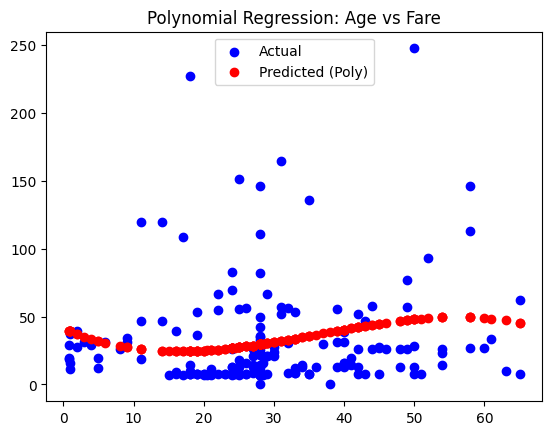

In [219]:
# Set up the poly inputs
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X1_train)
X_test_poly = poly.transform(X1_test)

# Use the poly inputs in the LR model
poly_model1 = LinearRegression()
poly_model1.fit(X_train_poly, y1_train)
y_pred_poly1 = poly_model1.predict(X_test_poly)

plt.scatter(X1_test, y1_test, color='blue', label='Actual')
plt.scatter(X1_test, y_pred_poly1, color='red', label='Predicted (Poly)')
plt.legend()
plt.title("Polynomial Regression: Age vs Fare")
plt.show()

### 5.5 Comparing All Models

We'll look at all the models we've trained thus far to see how they compare in their predictive power.

In [220]:
# creating repeatable reporter
def report(name, y_true, y_pred):
    print("### " + name)
    print(f"{name} R²: {r2_score(y_true, y_pred):.3f}")
    print(f"{name} RMSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"{name} MAE: {mean_absolute_error(y_true, y_pred):.2f}\n")

print("## Test Results")
report("Linear", y4_test, y_pred_test4)
report("Ridge", y4_test, y_pred_ridge)
report("ElasticNet", y4_test, y_pred_elastic)
report("Polynomial", y4_test, y_pred_poly)

## Test Results
### Linear
Linear R²: 0.361
Linear RMSE: 924.73
Linear MAE: 21.35

### Ridge
Ridge R²: 0.361
Ridge RMSE: 923.94
Ridge MAE: 21.33

### ElasticNet
ElasticNet R²: 0.390
ElasticNet RMSE: 882.04
ElasticNet MAE: 19.24

### Polynomial
Polynomial R²: 0.449
Polynomial RMSE: 797.81
Polynomial MAE: 17.11



### 5.6 Visualizing a Higher Order Polynomial

To illustrate the effects of higher-order polynomials, here is the same single-variable case from the plot in section 5.4 with a 9-degree (i.e. 3 times as complicated) polynomial:

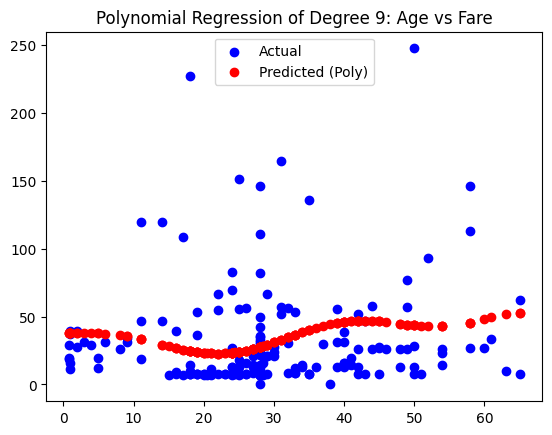

In [221]:
# Set up the poly inputs
order = 9
poly = PolynomialFeatures(degree=order)
X_train_poly = poly.fit_transform(X1_train)
X_test_poly = poly.transform(X1_test)

# Use the poly inputs in the LR model
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y1_train)
y_pred_poly9 = poly_model.predict(X_test_poly)

plt.scatter(X1_test, y1_test, color='blue', label='Actual')
plt.scatter(X1_test, y_pred_poly9, color='red', label='Predicted (Poly)')
plt.legend()
plt.title(f"Polynomial Regression of Degree {order}: Age vs Fare")
plt.show()

To my eye, the higher order polynomial in this case actually does tend to perform a bit better. The line of red dots more accurately follows what I'd preceive to be a moving average of the variables around it. It's predictive power is still quite weak, but it's slightly better than the cubic function. If I was doing any of this by hand it wouldn't be good enough to justify the effort.

## Section 6: Final Thoughts & Insights

### 6.1 Summarizing Findings

1. What features were most useful?

    In my original 4 cases, `Class`, `Sex`, and `Embark_Town` were most useful. Of those, I believe `Class` is the most impactful (I believe this because I once commented out Sex and Embark_Town and found that the R^2 value dropped by much less than the 2/3rd you'd expect if they were all equally important). 

2. What regression model performed the best?

    In this case the **Polynomial Regression** based on Case 4 predicted the best. It approached the ceiling that was found for linear regressions that factored in **all** available features. 

### 6.2 Discuss Challenges

1. Was fare hard to predict? Why?

    I think fare is hard to predict given the data we have available. Some folks just paid more. We CAN make **some** reasonable predictions using Class and potentially some other features, but the ceiling for how high I was able to get the R^2 value of any of my models was still less than 0.5. This means that, at best, I was able to find correlations explaining 50% of the variation of the output given all the inputs I tested. 

2. Did skew or outliers impact the models?

    I'd say outliers definitely impact the predictive power of the model. It isn't so much that they caused the predictions to perturb wildly from the average, but instead that the presence of the quantity of outliers that actually existed just go to show that there probably isn't any algorithm we could come up with using the parameters available to us in this dataset to truly approach anything close to R^2 = 1. I don't really see any skew to speak of.

### 6.3 Optional Next Steps

1. Try different features besides the ones used.

    I added a 5th case using all the available features. This case did perform better than any of the other 4 tested. I assume using literally **all** of the features isn't particularly necesary (as some are surely correlates of one another, not meaningfully separable). This work was done above, alongside cases 1 through 4.

## Table Generator

For the purposes of localizing my model performance characteristics, this code will generate a markdown table.

In [ ]:
def print_table_row(name, y_true, y_pred):
    a = f"{r2_score(y_true, y_pred):.3f}"
    b = f"{mean_squared_error(y_true, y_pred):.2f}"
    c = f"{mean_absolute_error(y_true, y_pred):.2f}"
    print(f"| {name} | {a} | {b} | {c} |")

print("# Model Comparison")
print("| Model | R² | MSE | MAE |")
print("|-------|----|------|-----|")
print_table_row("Linear", y4_test, y_pred_test4)
print_table_row("Ridge", y4_test, y_pred_ridge)
print_table_row("ElasticNet", y4_test, y_pred_elastic)
print_table_row("Polynomial degree 3", y4_test, y_pred_poly)

# Model Comparison
| Model | R² | RMSE | MAE |
|-------|----|------|-----|
| Linear | 0.361 | Linear RMSE: 924.73 | Linear MAE: 21.35 |
| Ridge | 0.361 | Ridge RMSE: 923.94 | Ridge MAE: 21.33 |
| ElasticNet | 0.390 | ElasticNet RMSE: 882.04 | ElasticNet MAE: 19.24 |
| Polynomial degree 3 | 0.449 | Polynomial degree 3 RMSE: 797.81 | Polynomial degree 3 MAE: 17.11 |
